In [1]:
import warnings
warnings.filterwarnings('ignore')
from itertools import izip

from IPython import get_ipython;   
get_ipython().magic('reset -sf')

import numpy as np
import pandas as pd

from warnings import warn
from sklearn import preprocessing
import itertools
import random
import math
#import cv2
import os
import scipy.io as spio

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
#from graph_tool.all import *
import seaborn as sns

import pydmd
import scipy
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv
from scipy.linalg import svd, svdvals
from scipy import ndimage

import scipy.io as spio
from matplotlib import animation
from IPython.display import HTML

HTML("""
<style>
 {
    display: table-cell;
    text-align: center;
   .output_png vertical-align: middle;http://localhost:8888/notebooks/DynamicCalcium.ipynb#
}
</style>
""")

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
from itertools import izip
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from shapely.geometry import MultiPoint, Point, Polygon
from matplotlib.animation import FuncAnimation
from matplotlib import colors
from shapely.geometry import LineString
from collections import defaultdict
from matplotlib import animation
from pyDOE import *
from scipy import integrate

In [2]:
from jupyterthemes import jtplot
jtplot.style()
np.random.seed(2400)

In [3]:
# Load shape file and adjacency matrices
adj_map=np.load("../VoronoiSahpeFiles/epitools/adj_map.npy").item()
adj_length_matrix=np.load("../VoronoiSahpeFiles/epitools/adj_length_matrix.npy")
new_vertices=np.load("../VoronoiSahpeFiles/epitools/new_vertices.npy")
area_profile=np.load("../VoronoiSahpeFiles/epitools/area_profile.npy")

#Form Laplacian and adj matix
laplacian_matrix=np.copy(adj_length_matrix)
for j in xrange(adj_length_matrix.shape[0]):
    laplacian_matrix[j,j]=-1.0*np.sum(adj_length_matrix[j,:])
adj_matrix= (laplacian_matrix>0).astype(int)

small_pouch_index=[]
centeriods= np.zeros((adj_length_matrix.shape[0],2))
for j in xrange(adj_length_matrix.shape[0]):
    x_center, y_center=new_vertices[j].mean(axis=0)
    #print(x_center,y_center)
    centeriods[j,0],centeriods[j,1]=x_center, y_center
    if (x_center-800)**2/2.0+(y_center+500)**2<600000: #20000
        small_pouch_index.append(j)



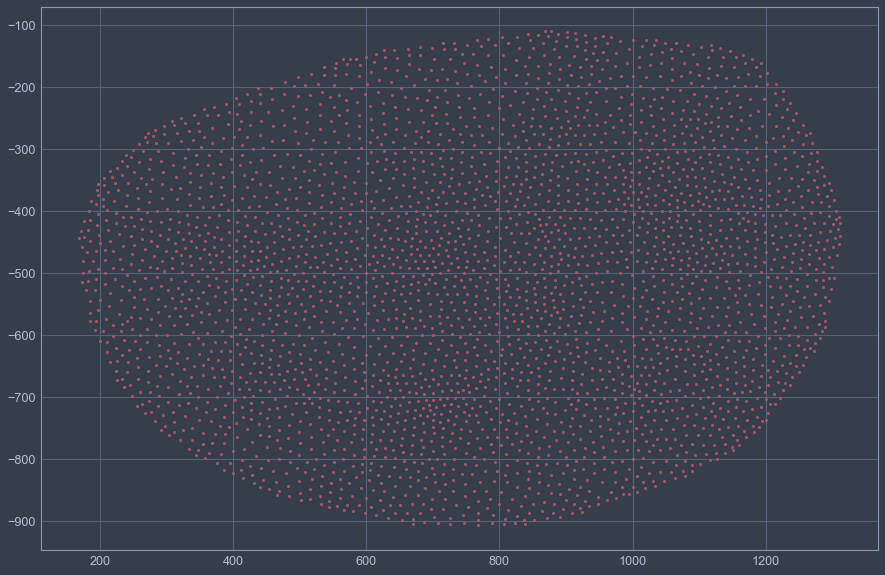

In [6]:
plt.figure(figsize=(15,10))
plt.plot(centeriods[:,0],centeriods[:,1],'.')
plt.plot(centeriods[small_pouch_index,0],centeriods[small_pouch_index,1],'r.')

In [7]:
small_pouch_index=np.array(small_pouch_index)

adj_length_matrix=adj_length_matrix[small_pouch_index,:]
adj_length_matrix=adj_length_matrix[:,small_pouch_index]
new_vertices=new_vertices[small_pouch_index]
new_area_profile=area_profile[small_pouch_index]
#Form Laplacian and adj matix
laplacian_matrix=np.copy(adj_length_matrix)
for j in xrange(adj_length_matrix.shape[0]):
    laplacian_matrix[j,j]=-1.0*np.sum(adj_length_matrix[j,:])
adj_matrix= (laplacian_matrix>0).astype(int)


In [8]:
adj_matrix_two=np.zeros_like(adj_matrix)
for i in xrange(adj_length_matrix.shape[0]):
    neighs_i=np.where(adj_matrix[i,:]==1)[0]
    adj_matrix_two[i,neighs_i]=1
    for j in neighs_i:
        neighs_j=np.where(adj_matrix[j,:]==1)[0]
        adj_matrix_two[i,neighs_j]=1
        adj_matrix_two[i,i]=0
        

In [15]:
np.mean(integrate.simps( disc_dynamics[:,0,:],dx=dt,axis=1))

208.5029787896136

# Systematic analysis

In [9]:
n_cells= adj_matrix.shape[0]
dt=.2
T=int(3600/dt)


#V_PLC=1.5#.13
K_PLC=.2#0.22
K_5=0.66
K_5_profile=0.66*np.ones((n_cells,1))
K_3=0.4
k_3=0.0

k_1=1.11
k_a=0.08
k_p=0.13
k_2=0.0203
V_SERCA=0.9
K_SERCA=0.1#.1
c_tot=2
beta=.185
tau=12.5
k_i=0.4
Dp_profile = [0.0,0.0005, 0.0010, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004,0.0045, 0.005, 0.007]#np.arange(0,0.008,0.002)
fraction_profile = [.01,0.02,.03,0.04,0.05]#np.arange(0.)
average_intensity = np.zeros((len(Dp_profile),len(fraction_profile)))

for i in xrange(len(Dp_profile)):
    for j in xrange(len(fraction_profile)):
        np.random.seed(2400)
        #Initialization
        disc_dynamics=np.zeros((n_cells,4,T)) # calcium, IP3, calcium_ER, ratio
        
        disc_dynamics[:,2,0] = (c_tot-disc_dynamics[:,0,0])/beta
        disc_dynamics[:,3,0]=np.random.uniform(.5,.7,size=(n_cells,1)).T

        disc_state=np.zeros((n_cells,T) , dtype='int')
        VPLC_state=np.random.uniform(.2,.7,(n_cells,1))
        K_SERCA_profile=np.random.uniform(0.1,0.1,(n_cells,1))


        record_laplacian=np.zeros((n_cells,T))

        D_p =Dp_profile[i]
        D_c =0.1*D_p

        tau_max=1000
        k_tau=1
        stimulated_cell_idxs=np.random.choice(n_cells, int(fraction_profile[j]*n_cells))
        VPLC_state[stimulated_cell_idxs,0]=.8
        print(D_p, int(fraction_profile[j]*n_cells))
        for step in xrange(1,T):
            ca=disc_dynamics[:,0,step-1].reshape(-1,1)
            ipt=disc_dynamics[:,1,step-1].reshape(-1,1)
            s=disc_dynamics[:,2,step-1].reshape(-1,1)
            r=disc_dynamics[:,3,step-1].reshape(-1,1)

            ca_laplacian=D_c*np.dot(laplacian_matrix,ca)
            ipt_laplacian=D_p*np.dot(laplacian_matrix,ipt)
            record_laplacian[:,step]=ipt_laplacian.reshape(1,-1)

            V_PLC=VPLC_state.reshape((n_cells,1))
            disc_dynamics[:,0,step]=(ca+dt*(ca_laplacian+ (k_1*( np.divide(np.divide(r*np.multiply(ca,ipt),(k_a+ca)),(k_p+ipt)) )**3 +k_2 )*(s-ca) -V_SERCA*(ca**2)/(ca**2+ K_SERCA_profile**2) )).T
            disc_dynamics[:,1,step]=(ipt+dt*(ipt_laplacian+ np.multiply(V_PLC,np.divide(ca**2,(ca**2+ K_PLC**2)))  -  np.multiply(K_5_profile,ipt) -k_3*ipt*np.divide(ca**2,(ca**2+ K_3**2)) )   ).T
            disc_dynamics[:,2,step]=(c_tot-ca.T)/beta
            disc_dynamics[:,3,step]=(r+dt*((k_tau**4+ca**4)/(tau_max*k_tau**4))*(( 1-r*(k_i+ca)/k_i))).T
        average_intensity[i,j]=np.mean(integrate.simps( disc_dynamics[:,0,:],dx=dt,axis=1))
        

(0.0, 32)
(0.0, 65)
(0.0, 97)
(0.0, 130)
(0.0, 162)
(0.0005, 32)
(0.0005, 65)
(0.0005, 97)
(0.0005, 130)
(0.0005, 162)
(0.001, 32)
(0.001, 65)
(0.001, 97)
(0.001, 130)
(0.001, 162)
(0.0015, 32)
(0.0015, 65)
(0.0015, 97)
(0.0015, 130)
(0.0015, 162)
(0.002, 32)
(0.002, 65)
(0.002, 97)
(0.002, 130)
(0.002, 162)
(0.0025, 32)
(0.0025, 65)
(0.0025, 97)
(0.0025, 130)
(0.0025, 162)
(0.003, 32)
(0.003, 65)
(0.003, 97)
(0.003, 130)
(0.003, 162)
(0.0035, 32)
(0.0035, 65)
(0.0035, 97)
(0.0035, 130)
(0.0035, 162)
(0.004, 32)
(0.004, 65)
(0.004, 97)
(0.004, 130)
(0.004, 162)
(0.0045, 32)
(0.0045, 65)
(0.0045, 97)
(0.0045, 130)
(0.0045, 162)
(0.005, 32)
(0.005, 65)
(0.005, 97)
(0.005, 130)
(0.005, 162)
(0.007, 32)
(0.007, 65)
(0.007, 97)
(0.007, 130)
(0.007, 162)


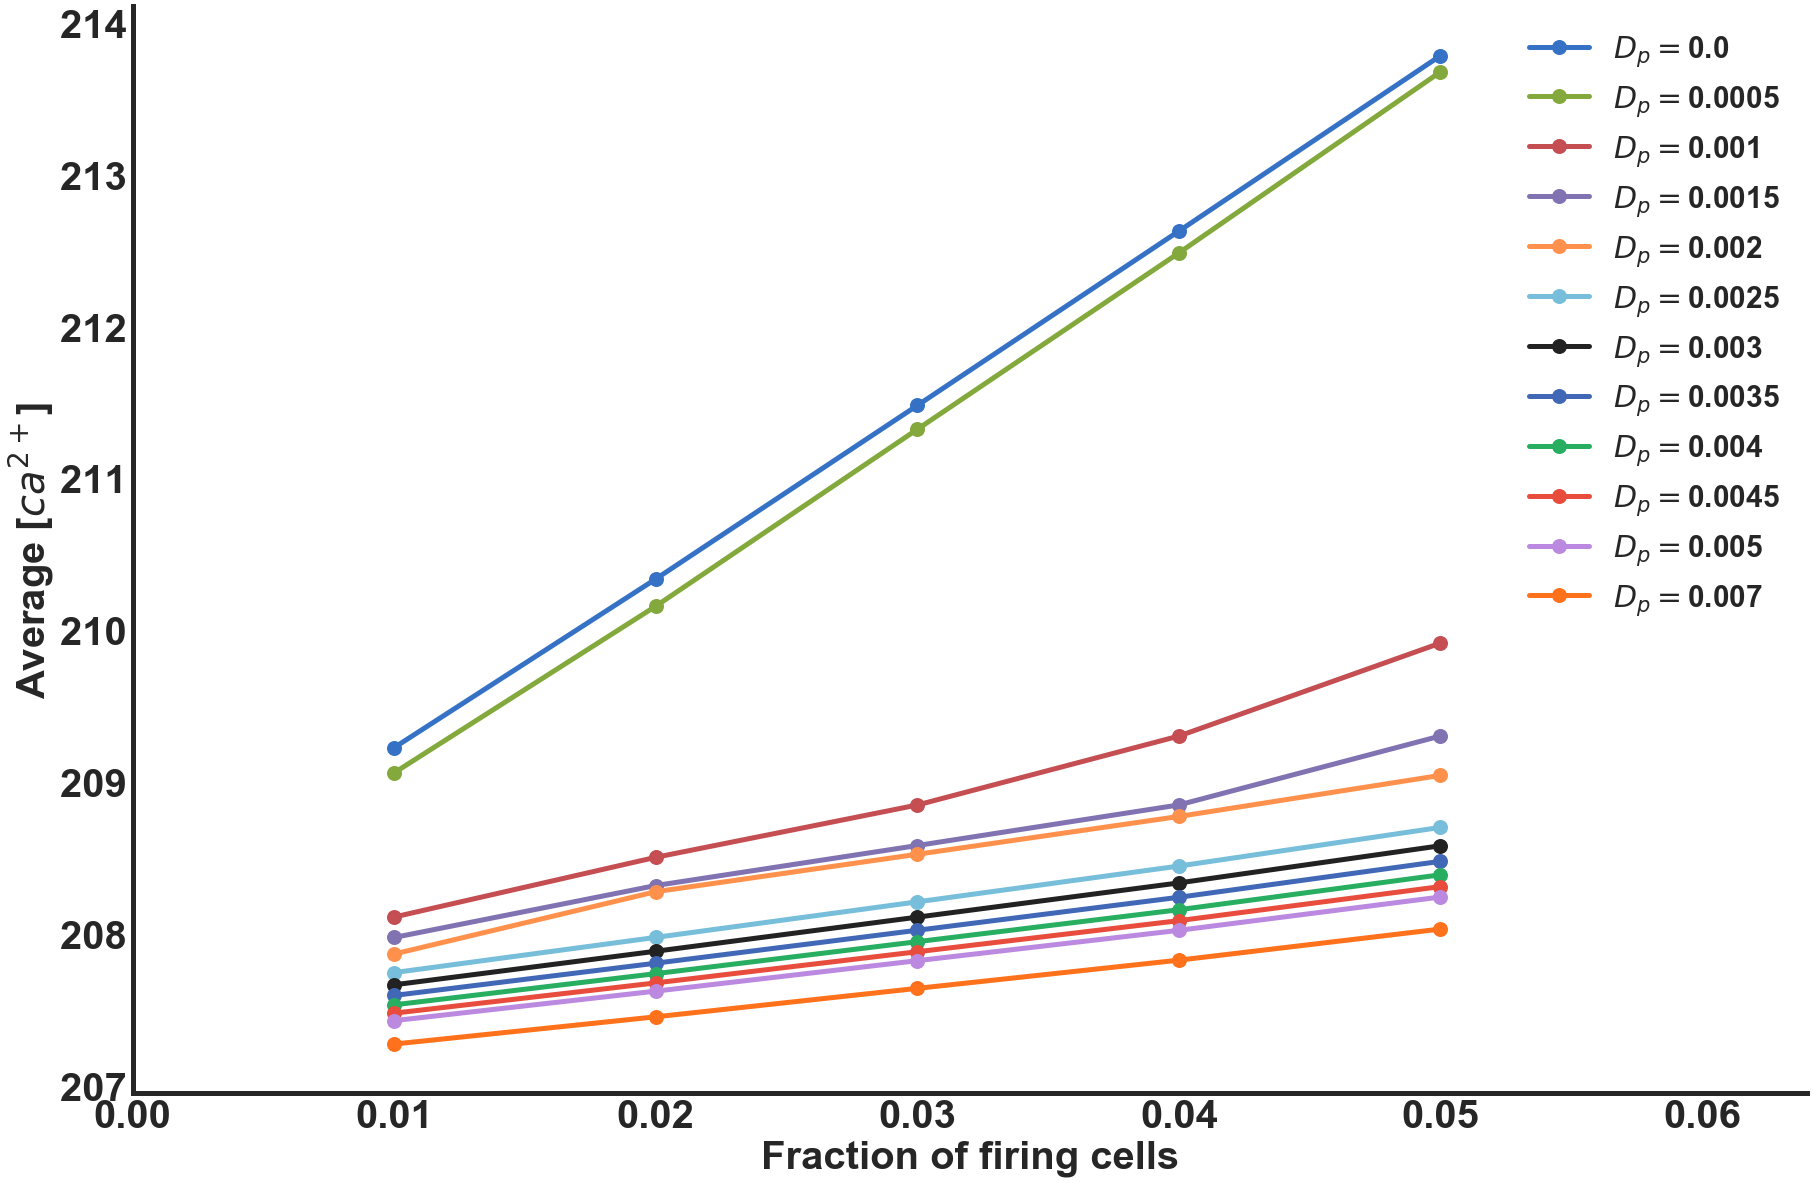

In [14]:
with sns.axes_style("white"):
    fig=plt.figure(figsize=(30,20))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=40,fontweight='bold')
    plt.xticks(fontsize=40,fontweight='bold')
    legend_properties = {'weight':'bold','size':30}
    my_markers=['o','s','^','*','X']
    for j in xrange(len(Dp_profile)):
        plt.plot(fraction_profile,average_intensity[j,:].T,'-',marker=my_markers[0],linewidth=5,markersize=15,label=r'$D_{p}=$'+str(Dp_profile[j] ))
    plt.xlabel("Fraction of firing cells",fontsize=40,fontweight='bold')
    plt.ylabel("Average "+r'[$ca^{2+}$]',fontsize=40,fontweight='bold')
    ax.legend(loc=0, shadow=True, prop=legend_properties)
    ax.set_xlim([0,.064])
    #ax.set_ylim([224,230])
fig.savefig("./figures/average_intensity_GJ2.pdf",transparent=True) 